# Bias Mitigation w/ the FairFace Dataset

In [17]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from pathlib import Path

## Loading the dataset

In [2]:
# Base data folder
data_dir = Path('data')

# Zip files
zip_025 = data_dir / 'fairface-img-margin025-trainval.zip'
zip_125 = data_dir / 'fairface-img-margin125-trainval.zip'

# Extraction directories
extract_dir_025 = data_dir / 'fairface_025'
extract_dir_125 = data_dir / 'fairface_125'

In [6]:
def extract_zip(zip_path, extract_to):
    if not extract_to.exists():
        print(f"Extracting {zip_path.name}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extracted to {extract_to}")
    else:
        print(f"{extract_to} already exists, skipping extraction.")

# Extract both datasets
extract_zip(zip_025, extract_dir_025)
extract_zip(zip_125, extract_dir_125)

data\fairface_025 already exists, skipping extraction.
data\fairface_125 already exists, skipping extraction.


In [5]:
# Load train and validation labels
train_labels = pd.read_csv(data_dir / "fairface_label_train.csv")
val_labels   = pd.read_csv(data_dir / "fairface_label_val.csv")

print(train_labels.head())

          file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian          True
1  train/2.jpg  30-39  Female      Indian         False
2  train/3.jpg    3-9  Female       Black         False
3  train/4.jpg  20-29  Female      Indian          True
4  train/5.jpg  20-29  Female      Indian          True


In [7]:
# List a few sample image paths from each
from glob import glob

samples_025 = glob(str(extract_dir_025 / "**/*.jpg"), recursive=True)
samples_125 = glob(str(extract_dir_125 / "**/*.jpg"), recursive=True)

print(f"Number of images (0.25): {len(samples_025)}")
print(f"Number of images (1.25): {len(samples_125)}")

print("Example 0.25 image:", samples_025[0])
print("Example 1.25 image:", samples_125[0])

Number of images (0.25): 97698
Number of images (1.25): 97698
Example 0.25 image: data\fairface_025\train\1.jpg
Example 1.25 image: data\fairface_125\train\1.jpg


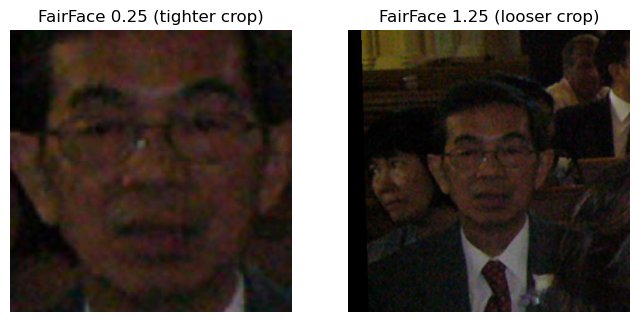

In [10]:
# Pick one example from each version
img_025 = mpimg.imread(samples_025[0])
img_125 = mpimg.imread(samples_125[0])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img_025)
axes[0].set_title("FairFace 0.25 (tighter crop)")
axes[1].imshow(img_125)
axes[1].set_title("FairFace 1.25 (looser crop)")
for ax in axes:
    ax.axis("off")
plt.show()

## Preprocessing

In [11]:
# Combine for overall statistics
df = pd.concat([train_labels, val_labels], ignore_index=True)
print(df.shape)
df.head()

(97698, 5)


,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [15]:
# Check for missing values
print(df.isnull().sum())

# Inspect data types and unique entries
print(df.info())
for col in ['age', 'gender', 'race']:
    print(f"{col}: {df[col].unique()}")

file            0
age             0
gender          0
race            0
service_test    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97698 entries, 0 to 97697
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file          97698 non-null  object
 1   age           97698 non-null  object
 2   gender        97698 non-null  object
 3   race          97698 non-null  object
 4   service_test  97698 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 3.1+ MB
None
age: ['50-59' '30-39' '3-9' '20-29' '40-49' '10-19' '60-69' '0-2'
 'more than 70']
gender: ['Male' 'Female']
race: ['East Asian' 'Indian' 'Black' 'White' 'Middle Eastern' 'Latino_Hispanic'
 'Southeast Asian']


## EDA

C:\Users\Nigel\AppData\Local\r-miniconda\envs\py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


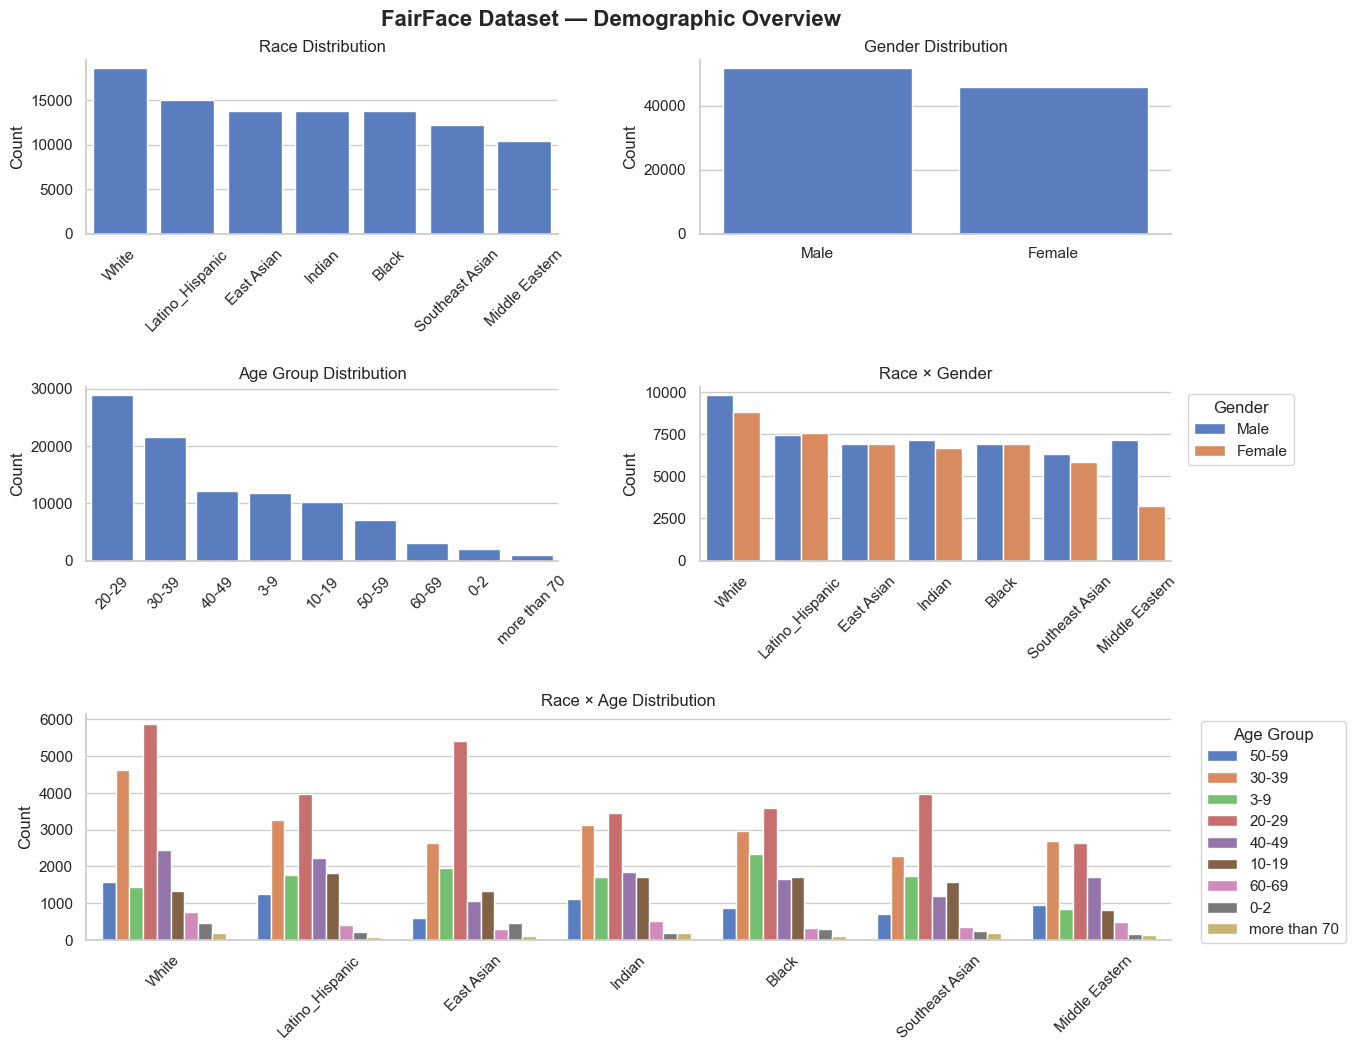

In [30]:
sns.set(style="whitegrid", palette="muted")
plt.rcParams.update({'figure.autolayout': True})

# --- Define grid (2 columns × 3 rows) ---
fig = plt.figure(figsize=(14, 10))

# hspace controls vertical padding between rows (bottom spacing)
grid = plt.GridSpec(3, 2, height_ratios=[1, 1, 1.3], hspace=0.8, wspace=0.3)

# --- Axes definitions ---
ax_race        = fig.add_subplot(grid[0, 0])
ax_gender      = fig.add_subplot(grid[0, 1])
ax_age         = fig.add_subplot(grid[1, 0])
ax_race_gender = fig.add_subplot(grid[1, 1])
ax_race_age    = fig.add_subplot(grid[2, :])   # spans both columns

# --- Plot 1: Race Distribution ---
sns.countplot(data=df, x='race',
              order=df['race'].value_counts().index,
              ax=ax_race)
ax_race.set_title("Race Distribution")
ax_race.tick_params(axis='x', rotation=45)

# --- Plot 2: Gender Distribution ---
sns.countplot(data=df, x='gender',
              order=df['gender'].value_counts().index,
              ax=ax_gender)
ax_gender.set_title("Gender Distribution")

# --- Plot 3: Age Distribution ---
sns.countplot(data=df, x='age',
              order=df['age'].value_counts().index,
              ax=ax_age)
ax_age.set_title("Age Group Distribution")
ax_age.tick_params(axis='x', rotation=45)

# --- Plot 4: Race × Gender ---
sns.countplot(data=df, x='race', hue='gender',
              order=df['race'].value_counts().index,
              ax=ax_race_gender)
ax_race_gender.set_title("Race × Gender")
ax_race_gender.tick_params(axis='x', rotation=45)
ax_race_gender.legend(title="Gender", bbox_to_anchor=(1.02, 1), loc="upper left")

# --- Plot 5: Race × Age (spanning both columns) ---
sns.countplot(data=df, x='race', hue='age',
              order=df['race'].value_counts().index,
              ax=ax_race_age)
ax_race_age.set_title("Race × Age Distribution")
ax_race_age.tick_params(axis='x', rotation=45)
ax_race_age.set_xlabel("")
ax_race_age.set_ylabel("Count")
ax_race_age.legend(title="Age Group", bbox_to_anchor=(1.02, 1), loc='upper left')

# --- Cosmetic cleanup ---
for ax in [ax_race, ax_gender, ax_age, ax_race_gender, ax_race_age]:
    sns.despine(ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("Count")

# --- Add bottom padding to entire figure ---
plt.subplots_adjust(bottom=0.05, top=0.93, hspace=0.9)  # increases bottom padding between rows

fig.suptitle("FairFace Dataset — Demographic Overview", fontsize=16, weight="bold", y=0.98)
plt.show()